In [32]:
import pandas as pd
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
sys.path.append('../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
import statistics 
from scipy import stats

In [33]:
df = pd.read_table('data_FisherSyndrome.txt', header = None, sep = '\s+')
Status, Patient, A, B, C = df.values.T

In [34]:
healthy_mask = Status == 0
sick_mask = Status == 1

dist_list = [A, B, C]
labels_list = ['A', 'B', 'C']

In [35]:
def plot_control(ax, xmin, xmax, Nbins, data, xlabel):
    # binwidth = (xmax - xmin) / Nbins
    ax.hist(data[healthy_mask], bins=Nbins, range=(xmin, xmax), histtype='step', label='Healthy')
    ax.hist(data[sick_mask], bins=Nbins, range=(xmin, xmax), histtype='step', label='Ill')
    ax.set(xlabel=xlabel, ylabel="Count", xlim=(xmin-1.0, xmax+1.0))
    ax.legend(frameon = False)

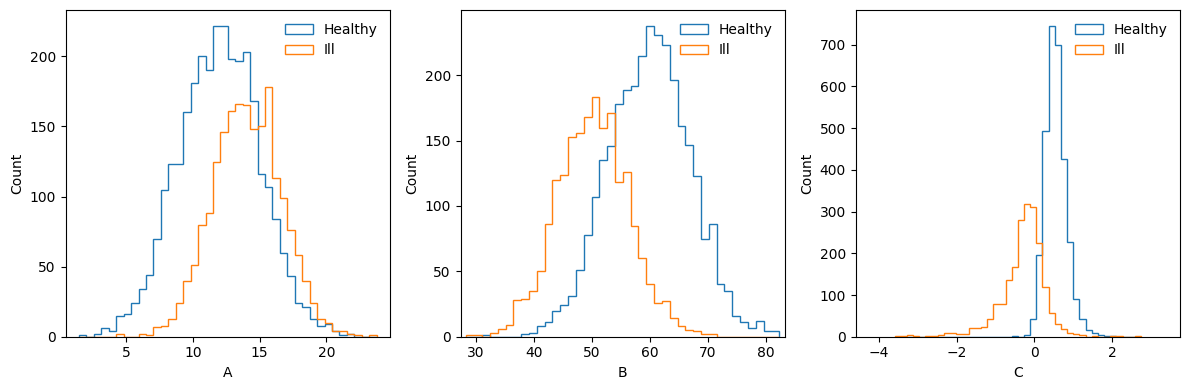

In [36]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for i, dist in enumerate(dist_list):
    plot_control(ax[i], min(dist), max(dist), 40, dist, labels_list[i])

plt.tight_layout()
fig.savefig('Distributions_prop4.png', dpi = 600)

In [37]:
A_count, bin_edges = np.histogram(A[sick_mask], bins=40)
A_val = 0.5*(bin_edges[1:] + bin_edges[:-1])
sA = np.sqrt(A_count)      # This is the standard for histograms - bin entries are Poisson distributed!

In [ ]:
# Since A is continous, the distribution cannot be Poisson or Binomial

In [42]:
Minuit.print_level = 0

y = A_count
ey = sA
x = A_val

non_zero_mask = y != 0

y = y[non_zero_mask]
ey = ey[non_zero_mask]
x = x[non_zero_mask]

In [46]:
def fit_gauss(x, N, mu, sigma):
    return N * stats.norm.pdf(x, loc = mu, scale = sigma)

def chi2_gauss(N, mu, sigma) :
    y_fit = fit_gauss(x, N, mu, sigma)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_gauss.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit_gauss = Minuit(chi2_gauss, N = len(y), mu = A_val.mean(), sigma = A_val.std(ddof=1)) # initial guess

# Perform the actual fit:
minuit_gauss.migrad()

Nvar = 2                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_gauss = minuit_gauss.fval                          # The chi2 value
Prob_gauss = stats.chi2.sf(Chi2_gauss, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2_gauss, Prob_gauss)

32.23777501122269 0.5048751234329685


In [52]:
def fit_cauchy(x, N, x0, gamma):
    return N * stats.cauchy.pdf(x, loc = x0, scale = gamma)

def chi2_cauchy(N, x0, gamma) :
    y_fit = fit_cauchy(x, N, x0, gamma)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_cauchy.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit_cauchy = Minuit(chi2_cauchy, N = len(x), x0 = A_val.mean(), gamma = A_val.std(ddof=1)) # initial guess

# Perform the actual fit:
minuit_cauchy.migrad()

Nvar = 2                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_cauchy = minuit_cauchy.fval                          # The chi2 value
Prob_cauchy = stats.chi2.sf(Chi2_cauchy, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2_cauchy, Prob_cauchy)

944.5985224321962 4.292370532674722e-177


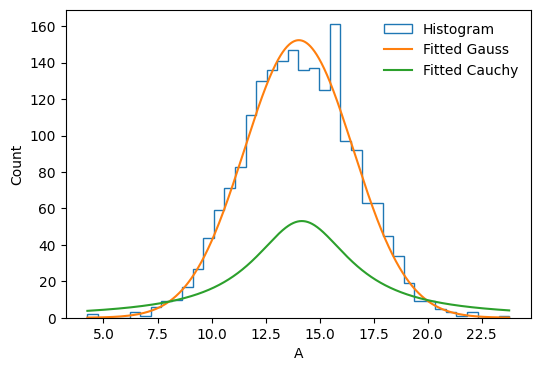

In [59]:
Amin, Amax = min(A[sick_mask]), max(A[sick_mask])
x_values = np.linspace(Amin, Amax, 10000)

fig, ax = plt.subplots(figsize = (6,4))

ax.hist(A[sick_mask], bins=40, histtype='step', label='Histogram')
ax.plot(x_values, fit_gauss(x_values, *minuit_gauss.values), label = 'Fitted Gauss')
ax.plot(x_values, fit_cauchy(x_values, *minuit_cauchy.values), label = 'Fitted Cauchy')

ax.set(xlabel='A', ylabel="Count", xlim=(Amin-1.0, Amax+1.0))
ax.legend(frameon = False)

In [62]:
def correlation(x, y):
    xy = x*y
    return (xy.mean() - x.mean() * y.mean()) / (x.std(ddof=1) * y.std(ddof=1))

In [63]:
corr_BC = correlation(B[sick_mask], C[sick_mask])
print(corr_BC)

-0.38807700972202097


In [72]:
frac_list = []

for c_test in np.linspace(-4, 3, 100):
    count_healthy = 0
    for c in C[healthy_mask]:
        if c > c_test:
            count_healthy += 1

    count_sick = 0
    for c in C[sick_mask]:
        if c < c_test:
            count_sick += 1

    frac = (count_healthy + count_sick) / len(C)
    frac_list.append(frac)

split = np.linspace(-4, 3, 100)[np.argmax(frac_list)]

print(max(frac_list))
print(split)

0.9072
0.17171717171717127


In [73]:
count_healthy = 0
for c in C[healthy_mask]:
    if c > split:
        count_healthy += 1

count_sick = 0
for c in C[sick_mask]:
    if c < split:
        count_sick += 1

In [75]:
type1 = (len(C[healthy_mask]) - count_healthy) / len(C[healthy_mask])
print('Type I error:', type1)

type2 = (len(C[sick_mask]) - count_sick) / len(C[sick_mask])
print('Type II error:', type2)

Type I error: 0.06
Type II error: 0.142
